In [ ]:
from feast import FeatureStore
import pandas as pd
import os

# Relative path from notebook
repo_path = os.path.join(os.path.dirname(""), "aqi_feature_store", "feature_repo")
fs = FeatureStore(repo_path=repo_path)
print("✅ Feature store loaded successfully")


✅ Feature store loaded successfully


In [2]:
# Load processed parquet (to access entity info)
parquet_path = r"C:\Users\HP\Desktop\AQI predictor\aqi_feature_store\feature_repo\data\processed_unscaled.parquet"
df_source = pd.read_parquet(parquet_path)
print("✅ Parquet source loaded successfully")

✅ Parquet source loaded successfully


In [3]:
# Prepare entity dataframe
entity_df = df_source[['sensor_id', 'time']].rename(columns={'time': 'event_timestamp'})

# Define feature list
feature_table_name = "karachi_air_features"
features_list = [
    f"{feature_table_name}:pm10",
    f"{feature_table_name}:pm2_5",
    f"{feature_table_name}:carbon_monoxide",
    f"{feature_table_name}:nitrogen_dioxide",
    f"{feature_table_name}:sulphur_dioxide",
    f"{feature_table_name}:ozone",
    f"{feature_table_name}:temperature_2m",
    f"{feature_table_name}:relative_humidity_2m",
    f"{feature_table_name}:dew_point_2m",
    f"{feature_table_name}:apparent_temperature",
    f"{feature_table_name}:pressure_msl",
    f"{feature_table_name}:windspeed_10m",
    f"{feature_table_name}:winddirection_10m",
    f"{feature_table_name}:aqi",
    f"{feature_table_name}:aqi_change",
    f"{feature_table_name}:aqi_pct_change"
]

# Fetch data
training_data = fs.get_historical_features(
    entity_df=entity_df,
    features=features_list
).to_df()

print("✅ Historical features pulled successfully")
print(training_data.head())
print("Total rows:", len(training_data))

✅ Historical features pulled successfully
      sensor_id           event_timestamp   pm10  pm2_5  carbon_monoxide  \
0  KHI_SENSOR_1 2025-04-20 03:00:00+00:00  130.4  44.25            173.0   
1  KHI_SENSOR_1 2025-04-20 04:00:00+00:00  130.4  44.25            167.0   
2  KHI_SENSOR_1 2025-04-20 05:00:00+00:00  130.4  44.25            258.0   
3  KHI_SENSOR_1 2025-04-20 06:00:00+00:00  130.4  44.25            556.0   
4  KHI_SENSOR_1 2025-04-20 07:00:00+00:00  130.4  44.25            556.0   

   nitrogen_dioxide  sulphur_dioxide  ozone  temperature_2m  \
0               5.9              6.1   88.0            26.5   
1               6.1              6.2   80.0            26.0   
2               8.2              6.8   76.0            25.5   
3              14.3              8.4   67.0            25.5   
4              22.6             10.8   56.0            25.7   

   relative_humidity_2m  dew_point_2m  apparent_temperature  pressure_msl  \
0                  71.0          20.8        

In [4]:
# Step 2: Train and Evaluate XGBoost Model

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [5]:
# Prepare data
data = training_data.copy()
X = data.drop(columns=["sensor_id", "event_timestamp", "aqi"])
y = data["aqi"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Train XGBoost
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

print("✅ XGBoost model trained successfully")

# Save model
model_path = r"C:\Users\HP\Desktop\AQI predictor\aqi_feature_store\xgb_aqi_model.pkl"
joblib.dump(xgb_model, model_path)
print(f"✅ Model saved at: {model_path}")

✅ XGBoost model trained successfully
✅ Model saved at: C:\Users\HP\Desktop\AQI predictor\aqi_feature_store\xgb_aqi_model.pkl


In [7]:
# Step 3: Evaluate Performance

y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 Model Evaluation:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

📊 Model Evaluation:
MSE: 5.74
RMSE: 2.40
MAE: 1.29
R²: 0.99


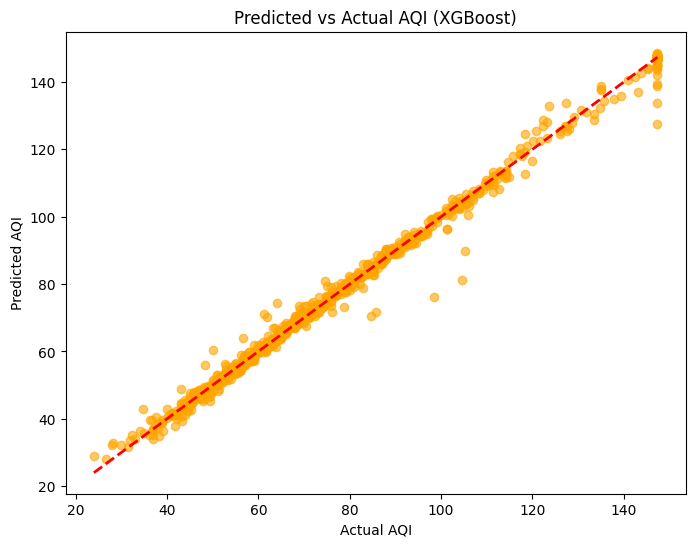

In [8]:
# Plot predicted vs actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Predicted vs Actual AQI (XGBoost)")
plt.show()

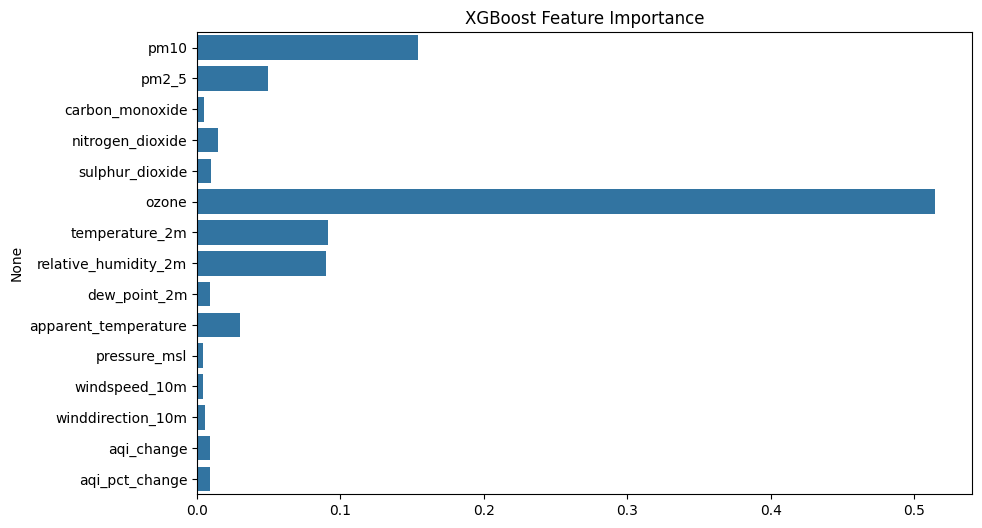

In [9]:
# Feature importance
plt.figure(figsize=(10,6))
sns.barplot(x=xgb_model.feature_importances_, y=X.columns)
plt.title("XGBoost Feature Importance")
plt.show()

COMPARISON OF RANDOM FOREST AND XGBOOST

📊 Model Performance Comparison:


,Model,MSE,RMSE,MAE,R²
0,Random Forest,1.85,1.36,0.29,1.00
1,XGBoost,5.74,2.40,1.29,0.99


C:\Users\HP\AppData\Local\Temp\ipykernel_20664\1277125351.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=comparison_df, palette="crest")


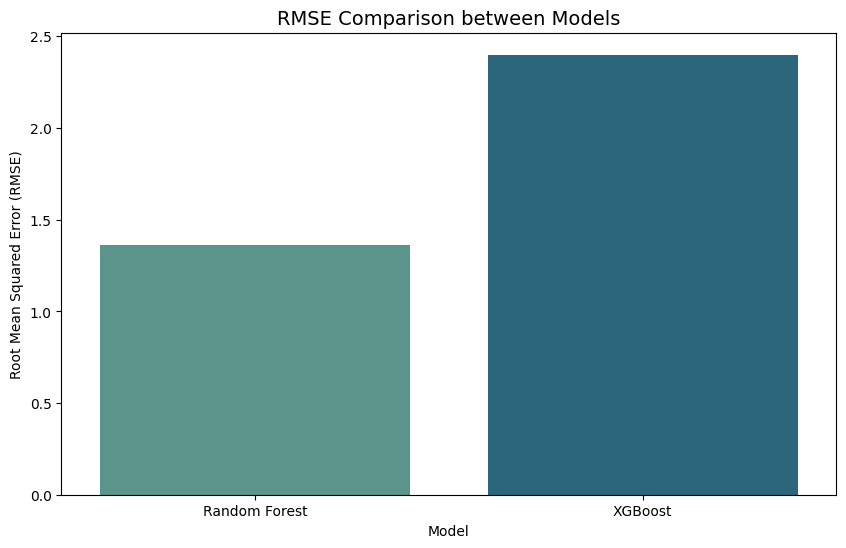

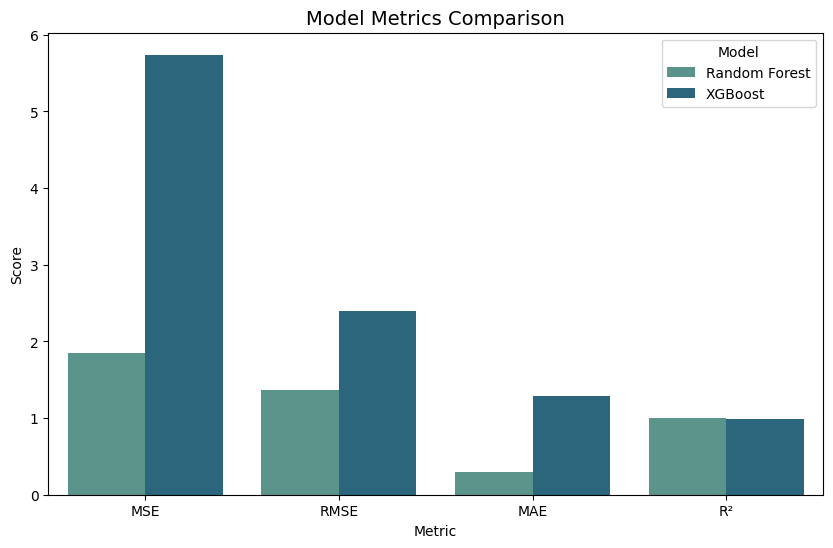

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Comparison Data
# -----------------------------
comparison_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "MSE": [1.85, 5.74],
    "RMSE": [1.36, 2.40],
    "MAE": [0.29, 1.29],
    "R²": [1.00, 0.99]
})

# Display metrics in table format
print("📊 Model Performance Comparison:")
display(comparison_df)

# -----------------------------
# Visualization
# -----------------------------
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="RMSE", data=comparison_df, palette="crest")
plt.title("RMSE Comparison between Models", fontsize=14)
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xlabel("Model")
plt.show()

# Plot all metrics (optional, more detailed)
comparison_df_melted = comparison_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Value", hue="Model", data=comparison_df_melted, palette="crest")
plt.title("Model Metrics Comparison", fontsize=14)
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Model")
plt.show()
